In [2]:
# Import packages
import matplotlib
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import matplotlib.pyplot as plt
import torch.utils.data as Data
import matplotlib.dates as mdates
from torch.autograd import Variable
import time
import datetime
import sklearn.metrics as sk
from dateutil.relativedelta import relativedelta
import calendar
import numpy as np
import joblib
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm.notebook import trange, tqdm

device0 = torch.device('cuda' if torch.cuda.is_available else 'cpu')
np.random.seed(16)
torch.manual_seed(16)
torch.cuda.manual_seed(16) 
torch.set_default_dtype(torch.float32)

In [3]:
torch.cuda.empty_cache()

In [4]:
# load data
X_spt=joblib.load('X_cov')
Z=joblib.load('Data_nonGaussian')
X_spt=X_spt.float().cuda()
Z=Z.float().cuda()
T=1095
S=11025
Z=Z.T
Z.shape

torch.Size([11025, 1095])

In [5]:
# SVD decomposition of training data
def SVD(Z_train):
    Z_tilde=Z_train-torch.mean(Z_train)
    u,s,vt=torch.linalg.svd(Z_tilde,full_matrices=False)
    return(u,s,vt)

def recompose(u,s,vt):
    tmp=u @ torch.diag(s) @ vt
    return(tmp)

# convert index from test_y_pred to coordinate
def convert(a):
    y=(a+9026)//105-1
    x=(a+9026)%105-1
    return x,y

# Model
# dim_output should be k=min(n,T)

class Net(nn.Module): 
    def __init__(self,dim_output, dim_input=11, dim_emb=64,dim_linear=128, dropout_input=0.8, dropout_emb=0.5, 
                 dropout_context=0.5,  l2=0.0001, batch_first=True):
        super(Net,self).__init__()
        self.batch_first = batch_first
        self.embedding = nn.Sequential(
            nn.Dropout(p=dropout_input),
            nn.Linear(dim_input, dim_emb, bias=False),
            nn.Dropout(p=dropout_emb)
        )
        init.xavier_normal_(self.embedding[1].weight)
        
        
        self.input = nn.Linear(dim_emb,dim_linear,bias=True)
        init.xavier_normal_(self.input.weight)
        self.input.bias.data.zero_()
        
        self.hidden1 = nn.Linear(dim_linear,2*dim_linear,bias=True)
        init.xavier_normal_(self.hidden1.weight)
        self.hidden1.bias.data.zero_()
        
        self.hidden2 = nn.Linear(2*dim_linear,2*dim_linear,bias=True)
        init.xavier_normal_(self.hidden2.weight)
        self.hidden2.bias.data.zero_()
        
        self.hidden3 = nn.Linear(2*dim_linear,2*dim_linear,bias=True)
        init.xavier_normal_(self.hidden3.weight)
        self.hidden3.bias.data.zero_()
        
        self.hidden4 = nn.Linear(2*dim_linear,2*dim_linear,bias=True)
        init.xavier_normal_(self.hidden4.weight)
        self.hidden4.bias.data.zero_()
        
        self.hidden5 = nn.Linear(2*dim_linear,dim_linear,bias=True)
        init.xavier_normal_(self.hidden5.weight)
        self.hidden5.bias.data.zero_()
        
        self.outputdnn = nn.Linear(dim_linear,dim_emb,bias=True)
        init.xavier_normal_(self.outputdnn.weight)
        self.outputdnn.bias.data.zero_()
        
        self.attention = nn.Linear(dim_emb,dim_emb,bias=True)
        init.xavier_normal_(self.attention.weight, gain=nn.init.calculate_gain('tanh'))
        self.attention.bias.data.zero_()
        
        
        self.output = nn.Sequential(
            nn.Dropout(p=dropout_context),
            nn.Linear(in_features=dim_emb, out_features=dim_output)
        )
        init.xavier_normal_(self.output[1].weight)
        self.output[1].bias.data.zero_()
        
        self.input2 = nn.Linear(dim_emb,dim_linear,bias=True)
        init.xavier_normal_(self.input2.weight)
        self.input2.bias.data.zero_()

        
        self.hidden6 = nn.Linear(dim_linear,2*dim_linear,bias=True)
        init.xavier_normal_(self.hidden6.weight)
        self.hidden6.bias.data.zero_()
        
        self.hidden7 = nn.Linear(2*dim_linear,2*dim_linear,bias=True)
        init.xavier_normal_(self.hidden7.weight)
        self.hidden7.bias.data.zero_()
        
        self.hidden8 = nn.Linear(2*dim_linear,2*dim_linear,bias=True)
        init.xavier_normal_(self.hidden8.weight)
        self.hidden8.bias.data.zero_()
        
        self.hidden9 = nn.Linear(2*dim_linear,dim_linear,bias=True)
        init.xavier_normal_(self.hidden9.weight)
        self.hidden9.bias.data.zero_()
        
        self.outputcoef = nn.Linear(dim_linear,dim_input,bias=True)
        init.xavier_normal_(self.outputcoef.weight)
        self.outputcoef.bias.data.zero_()
        

    def forward(self,x):
        
        emb = self.embedding(x)
        
        
        input0 = self.input(emb)
        input0 = F.relu(input0)
        
        input1 = self.hidden1(input0)
        input1 = F.relu(input1)
        
        input2 = self.hidden2(input1)
        input2 = F.relu(input2)
        
        input3 = self.hidden3(input2)
        input3 = F.relu(input3)
        
        input4 = self.hidden4(input3)
        input4 = F.relu(input4)
        
        input5 = self.hidden5(input4)
        input5 = F.relu(input5)
        
        output1 = self.outputdnn(input5)
        
        gamma = torch.tanh(self.attention(output1))
        
        context =  gamma*emb
        
        coefficient = self.output(context)
        
        input_cov = self.input2(emb)
        input_cov = F.relu(input_cov)
        
        input6 = self.hidden6(input_cov)
        input6 = F.relu(input6)
        
        input7 = self.hidden7(input6)
        input7 = F.relu(input7)
        
        input8 = self.hidden8(input7)
        input8 = F.relu(input8)
        
        input9 = self.hidden9(input8)
        input9 = F.relu(input9)
        
        output_coef=self.outputcoef(input9)
        
        intercept = output_coef*x
        
        intercept = torch.sum(intercept,1,keepdim=True)
        
        finaltemp = recompose(coefficient,s,vt) + intercept + spatial_mean
        
        return finaltemp,gamma,output_coef

In [6]:
# dim_output should be k=min(n,T)
net = Net(dim_output=1095).cuda()
print(net)

Net(
  (embedding): Sequential(
    (0): Dropout(p=0.8, inplace=False)
    (1): Linear(in_features=11, out_features=64, bias=False)
    (2): Dropout(p=0.5, inplace=False)
  )
  (input): Linear(in_features=64, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=256, bias=True)
  (hidden3): Linear(in_features=256, out_features=256, bias=True)
  (hidden4): Linear(in_features=256, out_features=256, bias=True)
  (hidden5): Linear(in_features=256, out_features=128, bias=True)
  (outputdnn): Linear(in_features=128, out_features=64, bias=True)
  (attention): Linear(in_features=64, out_features=64, bias=True)
  (output): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=64, out_features=1095, bias=True)
  )
  (input2): Linear(in_features=64, out_features=128, bias=True)
  (hidden6): Linear(in_features=128, out_features=256, bias=True)
  (hidden7): Linear(in_features=256, out

In [7]:
# split dataset
train_set = Data.TensorDataset(X_spt[:7025],Z[:7025,:])
train_loader=Data.DataLoader(dataset=train_set, batch_size=8000,shuffle=False)

valid_set = Data.TensorDataset(X_spt[7025:9025],Z[7025:9025,:])
valid_loader=Data.DataLoader(dataset=valid_set, batch_size=2000,shuffle=False)

test_set = Data.TensorDataset(X_spt[9025:],Z[9025:,:])
test_loader =Data.DataLoader(dataset=test_set, batch_size=2000,shuffle=False)

In [8]:
train_dataset=Z[:7025,:]
spatial_mean=torch.mean(train_dataset,0,True)
u,s,vt=SVD(train_dataset)


optimizer = torch.optim.Adam(net.parameters(),lr = 0.0001)
# optimizer = torch.optim.SGD(net.parameters(),lr =0.0001,momentum=0.9,nesterov=True)
loss_func = torch.nn.MSELoss()

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8000, eta_min=0, last_epoch=-1, verbose=False)

def epoch(loader,train=False):
    if train:
        net.train()
        mode = 'Train'
    else:
        net.eval()
        mode = 'Eval'
    
    true_value = []
    outputs = []
    attention =[]
    output_coefs = []
    losses = 0

    for step ,(batch_x,batch_z) in enumerate(loader):
        input_var=Variable(batch_x)
        target_var=Variable(batch_z)
    
        prediction,att,output_coef = net(input_var)
        loss = loss_func(prediction,target_var)
        
        attention.append(att.data)
        outputs.append(prediction.data)
        output_coefs.append(output_coef.data)
        losses=losses+loss.data
    
        # compute gradient and do update step
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return torch.cat(outputs, 0),torch.cat(attention,0),torch.cat(output_coefs,0),losses/len(loader)

In [9]:
# main
best_valid_epoch = 0
best_valid_loss = 1e10


train_losses = []
valid_losses = []
n_epochs=8000

time_start=time.time()

for ei in trange(n_epochs):
                
    train_y_pred, train_att, train_coef, train_loss = epoch(train_loader,train=True)

    train_losses.append(train_loss)

#     Eval
    valid_y_pred,valid_att,valid_coef, valid_loss = epoch(valid_loader)
    valid_losses.append(valid_loss)

    valid_y_pred = valid_y_pred.cpu()


    is_best = valid_loss < best_valid_loss

    if is_best:
        best_valid_epoch = ei
        best_valid_loss = valid_loss

    # evaluate on the test set
        test_y_pred,test_att,test_coef, test_loss = epoch(test_loader)
        
        train_coef_best = train_coef
        train_att_best = train_att
        train_y_pred_best = train_y_pred.cpu()
        test_y_pred = test_y_pred.cpu()
        
        
        with open('train_nonGaussian.txt', 'w') as f:
            f.write('Best Validation Epoch: {}\n'.format(ei))
            f.write('Best Validation Loss: {}\n'.format(best_valid_loss))
            f.write('Train Loss: {}\n'.format(train_loss))
            f.write('Test Loss: {}\n'.format(test_loss))

   
        torch.save(net,'Simu_model_local.pt')
    
    scheduler.step()

time_end=time.time()
print('Run Time (s):' ,time_end-time_start)
print('Run Time per Epoch (s):',(time_end-time_start)/n_epochs)

  0%|          | 0/8000 [00:00<?, ?it/s]

Run Time (s): 755.8406322002411
Run Time per Epoch (s): 0.09448007902503014


In [10]:
bestmodel=torch.load('Simu_model.pt')
paras = list(bestmodel.parameters())
pred_data,att,coef=bestmodel(X_spt)
print(bestmodel)

Net(
  (embedding): Sequential(
    (0): Dropout(p=0.8, inplace=False)
    (1): Linear(in_features=11, out_features=64, bias=False)
    (2): Dropout(p=0.5, inplace=False)
  )
  (input): Linear(in_features=64, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=256, bias=True)
  (hidden3): Linear(in_features=256, out_features=256, bias=True)
  (hidden4): Linear(in_features=256, out_features=256, bias=True)
  (hidden5): Linear(in_features=256, out_features=128, bias=True)
  (outputdnn): Linear(in_features=128, out_features=64, bias=True)
  (attention): Linear(in_features=64, out_features=64, bias=True)
  (output): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=64, out_features=1095, bias=True)
  )
  (input2): Linear(in_features=64, out_features=128, bias=True)
  (hidden6): Linear(in_features=128, out_features=256, bias=True)
  (hidden7): Linear(in_features=256, out

In [11]:
config = {
    "font.family": 'sans-serif',
    "font.sans-serif": ['Arial'],
    "font.size": 20,
    "mathtext.fontset": 'stixsans',
}
plt.rcParams.update(config)

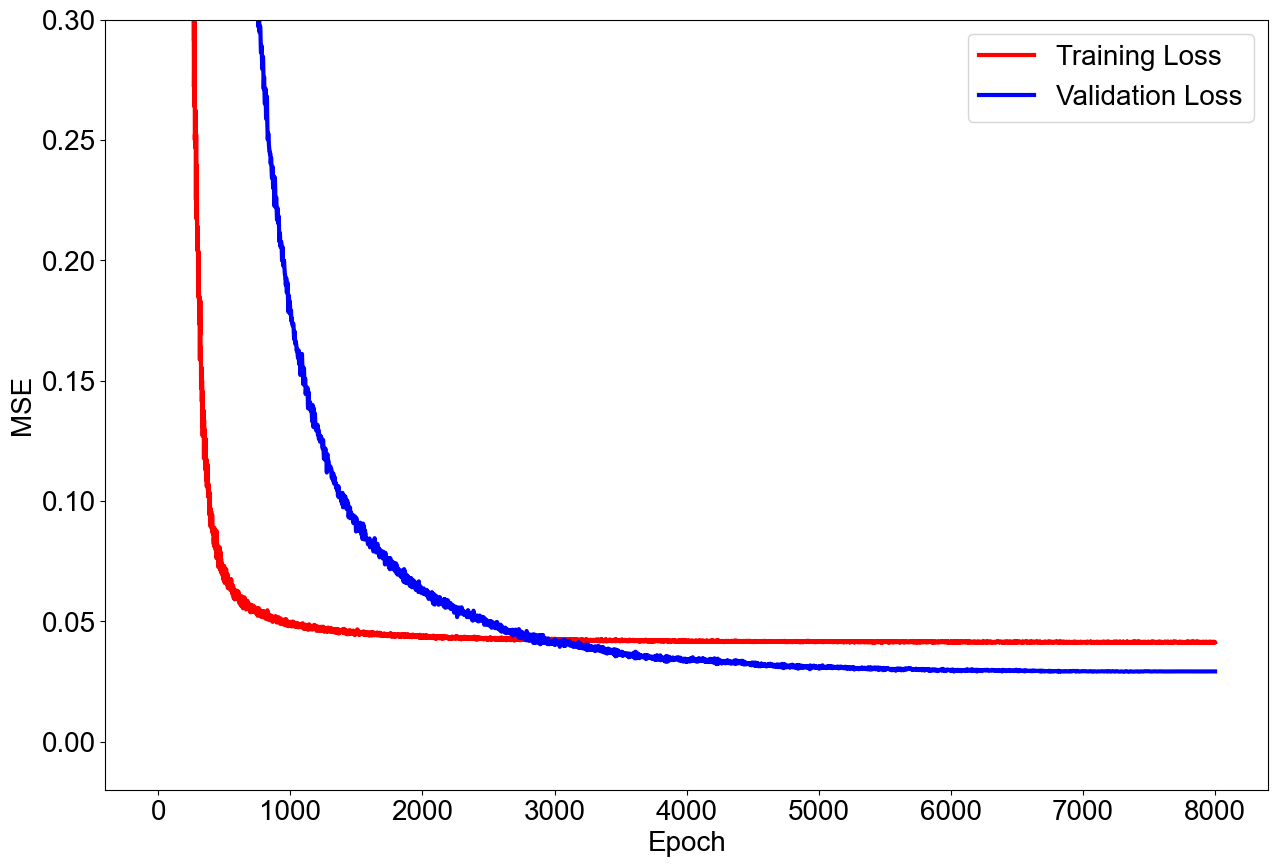

In [22]:
# Check loss convergence
for i in range(len(train_losses)):
    train_losses[i]=train_losses[i].cpu()
    valid_losses[i]=valid_losses[i].cpu()

x=[i for i in range(len(train_losses))]
plt.figure(figsize=(15,10))
plt.plot(x,np.array(train_losses),linewidth = 3,color="red",label='Training Loss')
plt.plot(x,np.array(valid_losses),linewidth = 3,color="blue",label='Validation Loss')
# plt.title(r'$\gamma$')
ax=plt.gca()
ax.set_ylabel(r'MSE')
ax.set_xlabel('Epoch')
plt.ylim(-0.02,0.3)
plt.legend()

In [ ]:
# Compute PI

n=len(train_set)
decay=0.0001
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()
            
def uncertainity_estimate(x, model, num_samples, l2):
    model.eval()
    enable_dropout(model)
    outputs=np.stack([model(x)[0].cpu().detach().numpy() for _ in range(num_samples)]).reshape(num_samples,1095).T
    Z_mean=outputs.mean(axis=1)
    Z_variance=outputs.var(axis=1)
    tau = np.square(l2) * (1. - 0.5) / (2. * n *decay )
    Z_variance += (1. / tau)
    Z_std = np.sqrt(Z_variance)

    return Z_mean, Z_std

Z_mean,Z_std = uncertainity_estimate(X_spt[10659].reshape(1,len(X_spt[10659])),bestmodel,1000,0.1)
Z_upper=test_y_pred[1634]+1.96*Z_std
Z_lower=test_y_pred[1634]-1.96*Z_std
Z_var=np.square(Z_std)

In [12]:
# Generate map
simu_pred=pred_data.cpu().detach()

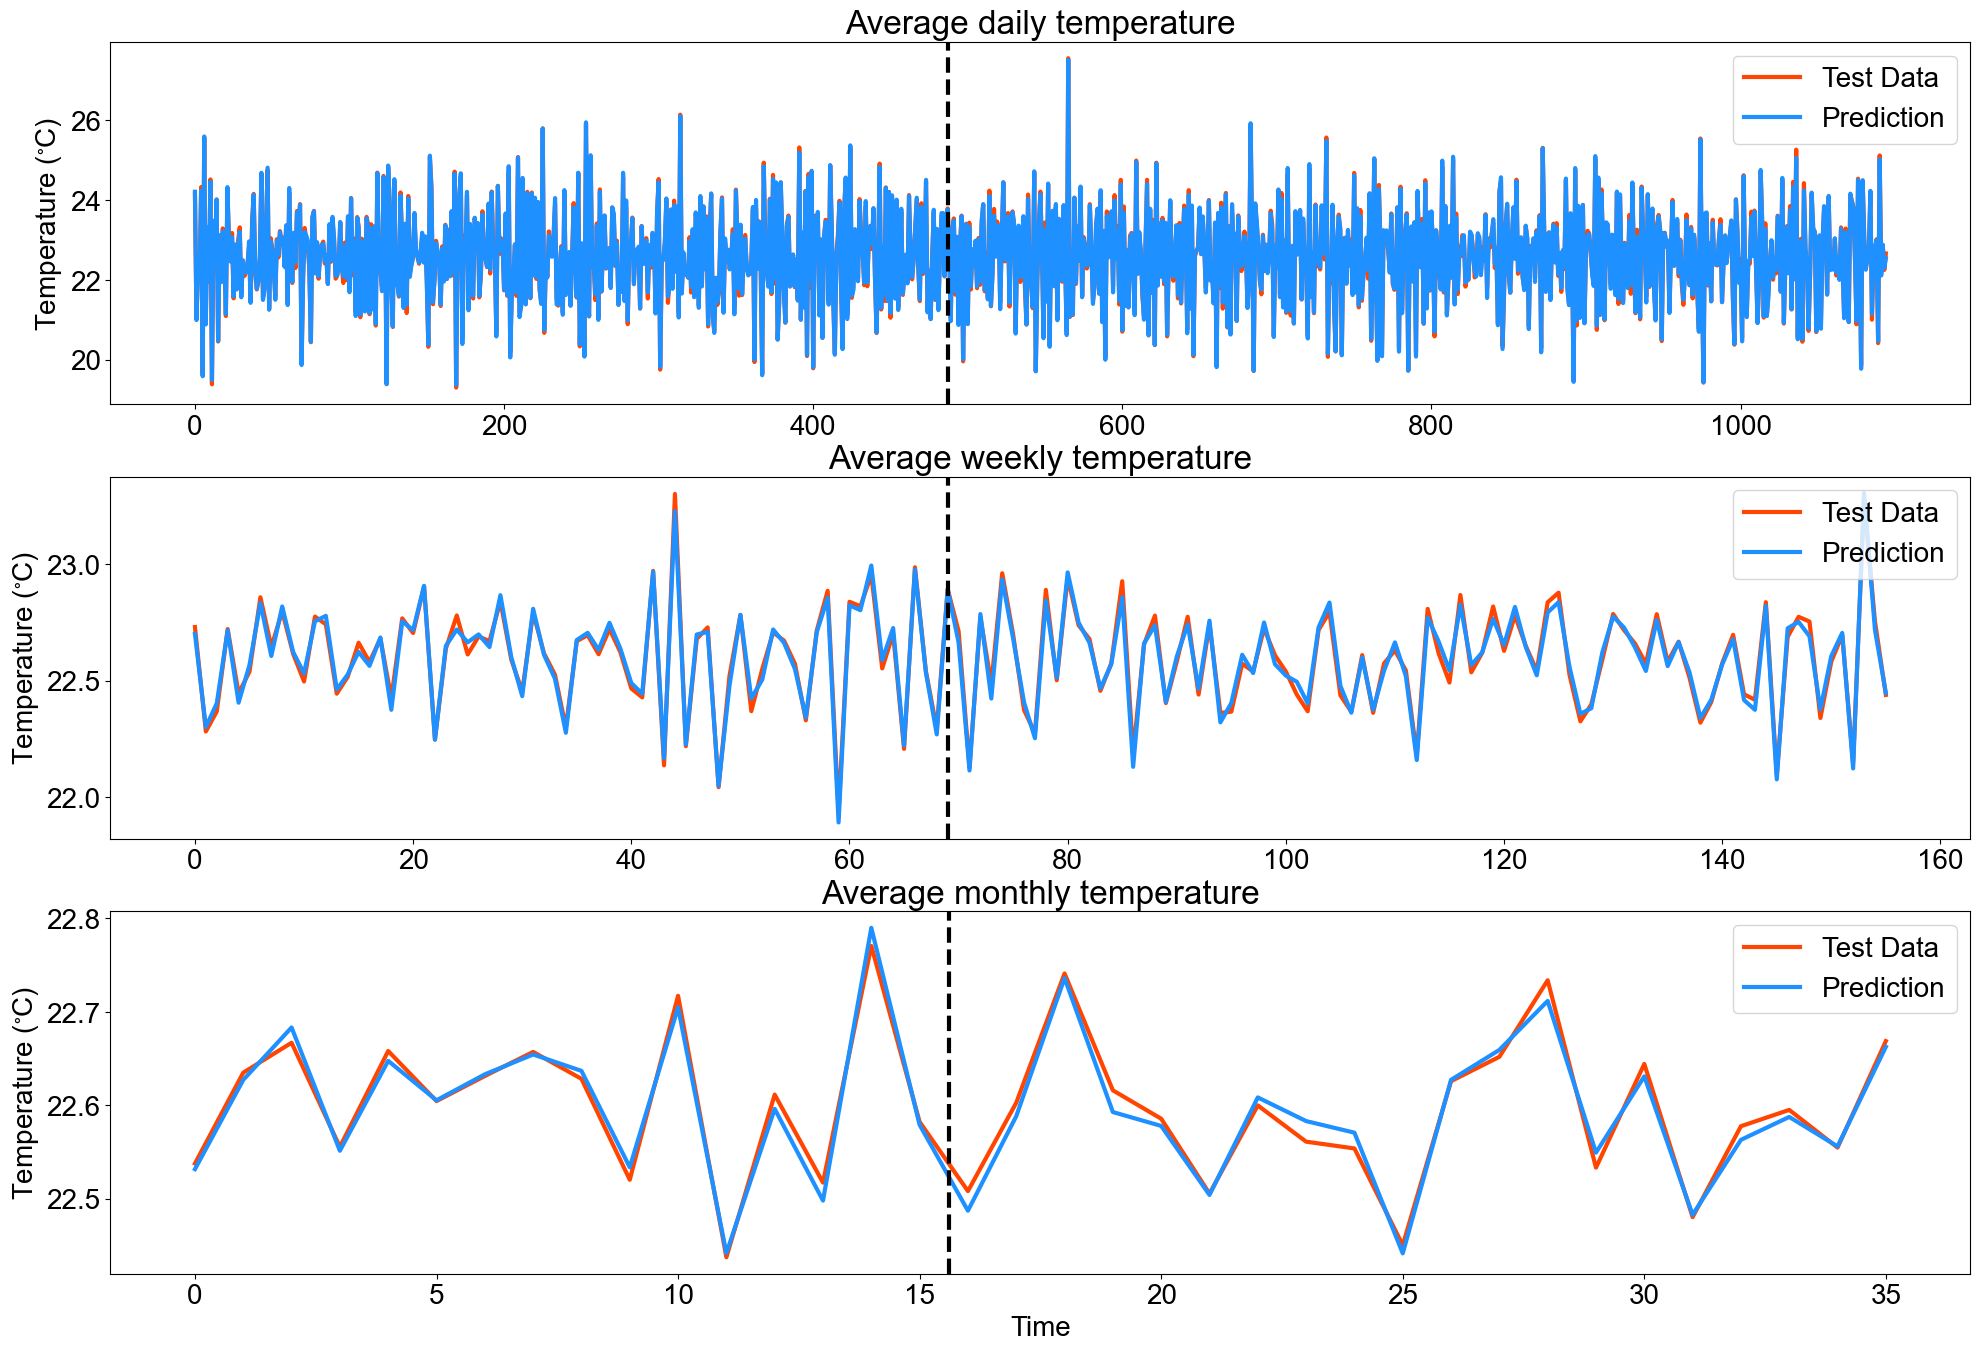

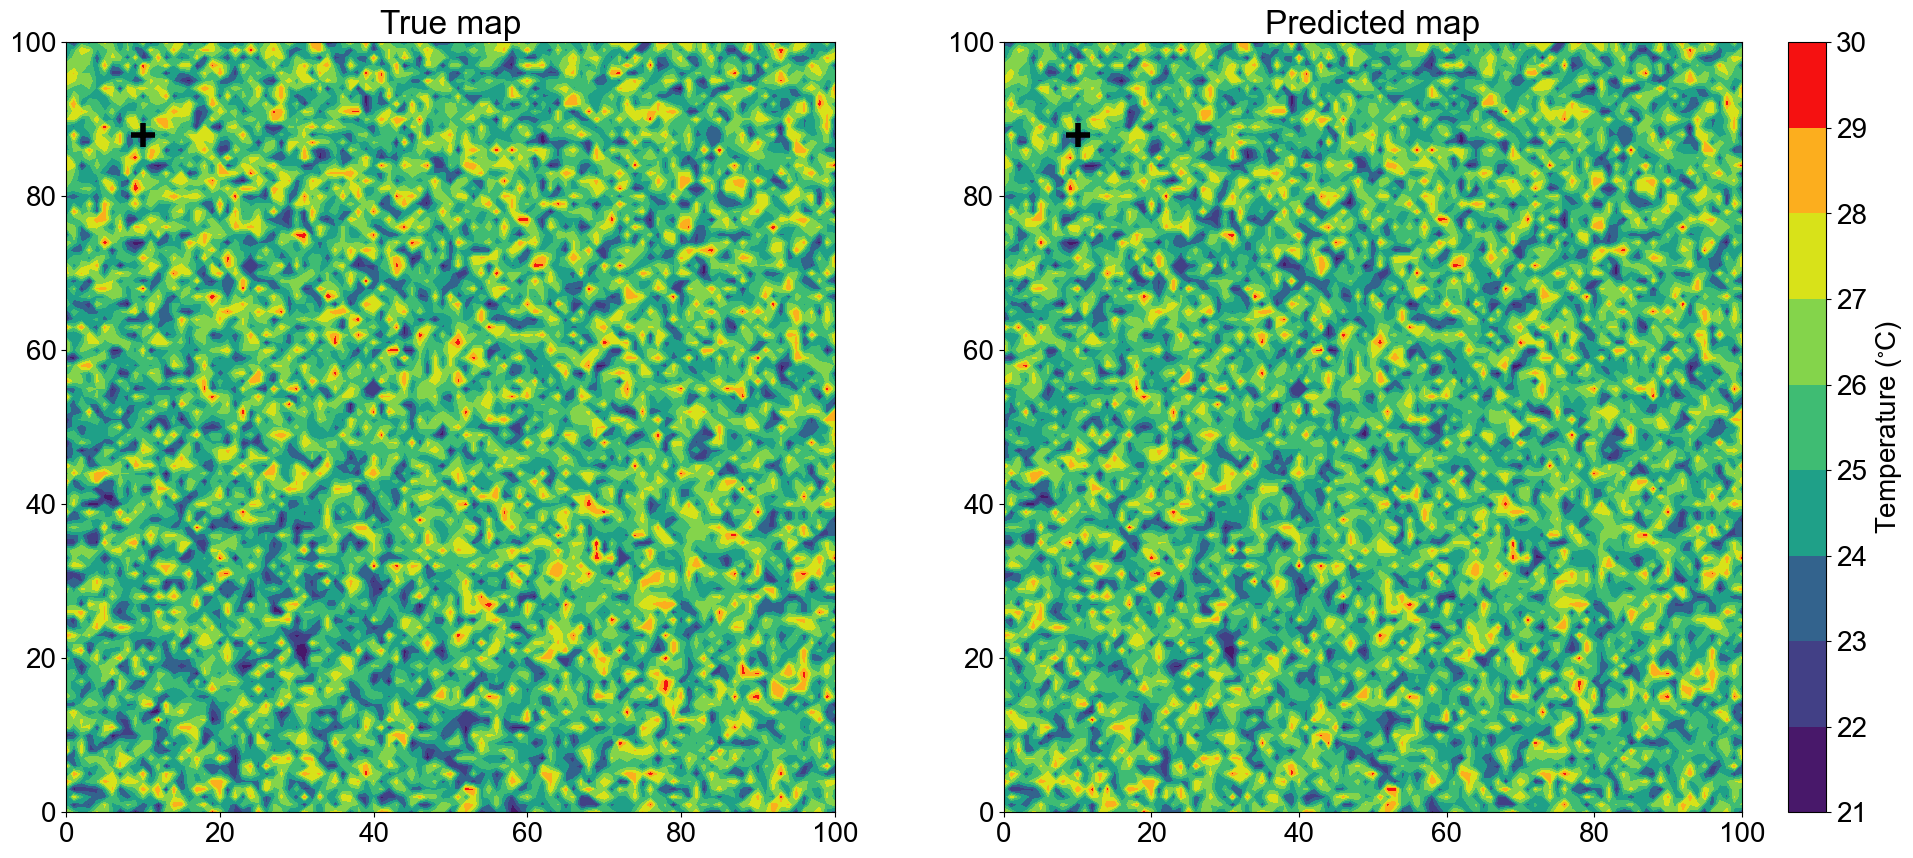

In [19]:
test_y_true=Z[9025:,:].cpu()

loc_x, loc_y=10,88
t=487
def timeconvert_week(t):
    return((t+1)/7-1)

def timeconvert_month(t):
    return((t+1)/30-1)

true_map=Z[:,t].reshape(105,105).cpu()
simu_map=simu_pred[:,t].reshape(105,105)


plt.figure(figsize=(24,16))

plt.subplot(3,1,1)
time=[]
x=range(1095)
plt.plot(x,np.array(test_y_true[1634,:]),linewidth = 3,color="orangered",label='Test Data')
plt.plot(x,np.array(test_y_pred[1634,:]),linewidth = 3,color="dodgerblue",label='Prediction')
plt.fill_between(x,Z_lower,Z_upper,color="dodgerblue",alpha=0.3,label='95% PI')
plt.title('Average daily temperature')
ax=plt.gca()
plt.axvline(t,linewidth = 3,linestyle = "dashed",color="black")
ax.set_ylabel(r'Temperature ($^{\circ}$C)')
plt.legend(loc = 'upper right')

plt.subplot(3,1,2)
x=range(156)
true_week=[np.mean(np.array(test_y_true[1634,:])[i*7:(i+1)*7]) for i in range(156)]
pred_week=[np.mean(np.array(test_y_pred[1634,:])[i*7:(i+1)*7]) for i in range(156)]
vari_week=[np.sum(np.array(Z_var)[i*7:(i+1)*7])/49 for i in range(156)]
pred_week_upper=pred_week+1.96*np.sqrt(vari_week)
pred_week_lower=pred_week-1.96*np.sqrt(vari_week)
plt.title('Average weekly temperature')
plt.plot(x,true_week,linewidth = 3,color="orangered",label='Test Data')
plt.plot(x,pred_week,linewidth = 3,color="dodgerblue",label='Prediction')
plt.fill_between(x,pred_week_lower,pred_week_upper,color="dodgerblue",alpha=0.3,label='95% PI')
ax=plt.gca()
plt.axvline(69,linewidth = 3,linestyle = "dashed",color="black")
ax.set_ylabel(r'Temperature ($^{\circ}$C)')
plt.legend(loc = 'upper right')

plt.subplot(3,1,3)
true_month=[]
pred_month=[]
vari_month=[]
x=[datetime.date(2010,1,1)+relativedelta(months=i) for i in range(36)]
y=range(36)
for i in range(36):
    if (i+1)%12==0:
        true_month.append(np.mean(np.array(test_y_true[1634,:])[(x[i]-x[0]).days:(x[i]-x[0]).days+31]))
        pred_month.append(np.mean(np.array(test_y_pred[1634,:])[(x[i]-x[0]).days:(x[i]-x[0]).days+31]))
        vari_month.append(np.sum(np.array(Z_var)[(x[i]-x[0]).days:(x[i]-x[0]).days+31])/np.square(31))
    else:
        true_month.append(np.mean(np.array(test_y_true[1634,:])[(x[i]-x[0]).days:(x[i]-x[0]).days+calendar.mdays[(i+1)%12]]))
        pred_month.append(np.mean(np.array(test_y_pred[1634,:])[(x[i]-x[0]).days:(x[i]-x[0]).days+calendar.mdays[(i+1)%12]]))
        vari_month.append(np.sum(np.array(Z_var)[(x[i]-x[0]).days:(x[i]-x[0]).days+calendar.mdays[(i+1)%12]])/np.square(30))
pred_month_upper=pred_month+1.96*np.sqrt(vari_month)
pred_month_lower=pred_month-1.96*np.sqrt(vari_month)
plt.title('Average monthly temperature')
plt.plot(y,true_month,linewidth = 3,color="orangered",label='Test Data')
plt.plot(y,pred_month,linewidth = 3,color="dodgerblue",label='Prediction')
plt.fill_between(y,pred_month_lower,pred_month_upper,color="dodgerblue",alpha=0.3,label='95% PI')
ax=plt.gca()
plt.axvline(15.6,linewidth = 3,linestyle = "dashed",color="black")
ax.set_ylabel(r'Temperature ($^{\circ}$C)')
ax.set_xlabel('Time')
plt.legend(loc = 'upper right')

# plt.savefig('timeseries_nonGaussian.pdf')

fig, ax = plt.subplots(1, 2, figsize=(24,10),gridspec_kw={'width_ratios': [1, 1.2]})

x = y = range(105)
vmin = np.array(simu_map).min() 
vmax = np.array(simu_map).max() 


colors = ["#48186a", "#424086", "#33638d", "#26828e", "#1fa088", "#3fbc73", "#84d44b", "#d8e219", "#fcae1e",'#f51111']
levels = len(colors)-1
cm     = matplotlib.colors.ListedColormap(colors)

contourf1=ax[0].contourf(x,y,np.array(true_map),levels=levels, cmap=cm, linestyles='None', vmin=vmin, vmax=vmax)
ax[0].scatter(loc_x, loc_y, c ='black', marker='+',linewidth=4, s=300)
# cbar = fig.colorbar(contourf,label='Temperature ($^{\circ}$C)')
ax[0].set_title('True map')
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,100)


vmin = np.array(simu_map).min() 
vmax = np.array(simu_map).max() 

colors = ["#48186a", "#424086", "#33638d", "#26828e", "#1fa088", "#3fbc73", "#84d44b", "#d8e219", "#fcae1e",'#f51111']
levels = len(colors)-1
cm     = matplotlib.colors.ListedColormap(colors)


contourf2=ax[1].contourf(x,y,np.array(simu_map),levels=levels, cmap=cm, linestyles='None', vmin=vmin, vmax=vmax)
cbar = fig.colorbar(contourf2,label='Temperature ($^{\circ}$C)')
ax[1].scatter(loc_x, loc_y, c ='black', marker='+',linewidth=4, s=300)
ax[1].set_title('Predicted map')
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,100)

# plt.savefig('map_nonGaussian.pdf')

In [16]:
# Compute contribution coefficient

phi=torch.diag(s) @ vt
mean=torch.mean(phi, dim=1)
gamma=train_att_best
gamma=gamma.T
Wemb=paras[0]
W=paras[17]
b=paras[18]

def calc_spt_coef(i,j):
    return((((gamma[:,i]*Wemb[:,j]).reshape(1,64)@W.T)@mean.reshape(1095,1))+train_coef_best[i,j]).detach().cpu().numpy()

contribution=[[] for i in range(11)]
for j in trange(11):
    for i in range(7025):
        contribution[j].append(calc_spt_coef(i,j))

res=[]
for i in range(11):
    res.append(np.mean([j for j in contribution[i] if j!=0]))
res[1:]=res[1:]-min(res[1:])
print('Contribution coefficient:',res)

  0%|          | 0/11 [00:00<?, ?it/s]

Contribution coefficient: [2.0017273, 0.0, 0.49846494, 1.011555, 1.4946146, 2.005499, 2.520917, 3.0233173, 3.5243828, 4.006457, 4.5151453]
